In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM
from scipy import stats
import json

### Data Input

In [10]:
#load data
d = pd.read_csv('rab5traj.csv')

uid = np.unique(d['pid'])
data = d[d['pid']==11]
# data = d[d['pid']==15]
# data = d[d['pid']==24]
# data = d[d['pid']==33]
    
def downsample(data_input, down_int, start_index=0):
    
    data_out = data_input.iloc[start_index::down_int]
    return data_out

### Displacements and exponent prediction

In [11]:
#load neural network model
model = tf.keras.models.load_model("model3dense_n20.h5")

def find_displacement(x_data,y_data,start_index=0):
#calculate displacements
    #x_data = np.array(x_data.data)
    #y_data = np.array(y_data.data)
    disps = np.sqrt(np.power(x_data-x_data[0],2) + np.power(y_data-y_data[0],2))
    
    return disps 


def estimate_hurst(disps,time):
    
    h = np.array([])
    ht = np.array([])
    for i in range(10,len(disps)-11):
        #sample of 20 points to calculate hurst exponent for
        inx = disps[(i-10):(i+11)]
        #apply differencing and normalization on the data
        inx = np.array([(inx[1:]-inx[0:-1])/(np.amax(inx)-np.amin(inx))])
        test = model.predict(inx,verbose=0)
        h=np.append(h,test[0][0])
        ht = np.append(ht,time[i])
        
    return h,ht

In [12]:
def dsample_est_hurst(data_in,ds_rate):
    """
    Args:
        data_in: pandas dataframe
        ds_rate: int, downsampling step size
    Returns:
        h_arr: 2D np array
        ht_arr: 2D np array
    """
    
    h_arr = np.empty((ds_rate,(len(data_in)//ds_rate)-21))
    ht_arr = np.empty((ds_rate,(len(data_in)//ds_rate)-21))
    
    for i in np.arange(ds_rate):
        
        downsampled_data = downsample(data_in, ds_rate, i)
        x = np.array(downsampled_data['x'])
        y = np.array(downsampled_data['y'])
        t = np.array(downsampled_data['t'])
        displacements = find_displacement(x,y)
        h,ht = estimate_hurst(displacements,t)
        
        if len(h)>np.shape(h_arr)[1]:
            h=h[:-1]
            ht=ht[:-1]
            
        h_arr[i] = h
        ht_arr[i] = ht
        
    return h_arr,ht_arr


def average_hurst(h_arr, ht_arr):
    """
    """
    h_average_arr = np.mean(h_arr, axis=0)
    ht_average_arr = np.mean(ht_arr, axis=0)
    
    return h_average_arr, ht_average_arr

In [95]:
h2,ht2 = dsample_est_hurst(data,2)

In [96]:
h3,ht3 = dsample_est_hurst(data,3)

In [97]:
def plot_downsampled_hurst(h_arr, ht_arr):
    """
    """
    h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)
    
    for i in np.arange(len(h_arr)):
        plt.plot(ht_arr[i], h_arr[i], alpha=0.5)
    plt.plot(ht_av_arr, h_av_arr, label='mean H', color='k')
    plt.axhline(0.5, c='r')
    plt.xlabel('t')
    plt.ylabel('H')
    plt.title('Downsampled data, step size {}'.format(len(h_arr)))
    plt.legend()
    plt.show()
    
plot_downsampled_hurst(h2, ht2)
plot_downsampled_hurst(h3, ht3)

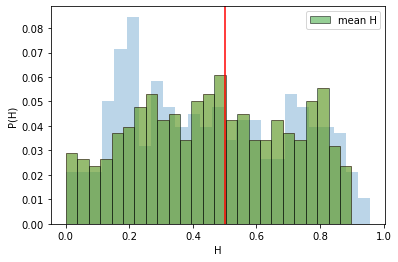

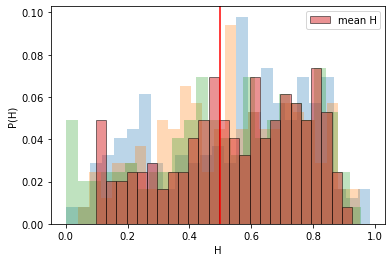

In [104]:
def plot_hist_2D(h_arr, ht_arr, nbins):
    """
    """
    for i in np.arange(len(h_arr)):
        counts, bins = np.histogram(h_arr[i], nbins)
        normalised_counts = counts/len(h_arr[i])  # normalisation so total counts = 1
        plt.hist(bins[:-1], bins, weights=normalised_counts, alpha=0.3)
        
    h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)
    counts_av, bins_av = np.histogram(h_av_arr, nbins)
    normalised_counts_av = counts/len(h_av_arr)
    plt.hist(bins_av[:-1], bins_av, weights=normalised_counts_av, label='mean H', alpha=0.5, ec='black')
    
    plt.xlabel('H')
    plt.ylabel('P(H)')
    plt.axvline(0.5, color='r')
    plt.legend()
    plt.show()

%matplotlib inline
plt.figure()
plot_hist_2D(h2, ht2, 25)
plot_hist_2D(h3, ht3, 25)
plt.show()

### 3D histogram

3D histogram:<br>
x axis is H.<br>
y axis is step size used for that downsampled data set.<br>
z axis is normalised average counts.<br>

In [120]:
def get_3D_hist_data(data_in, step_sizes, nbins):
    """
    Args:
        data_in: pandas dataframe
        step_sizes: array of int
        nbins: int, number of histogram bins
    Returns:
        normalised_counts_all: 2D np array, each row is normalised average counts for a given step size
        bins_all: 2D np array, each row is bin edges for a given step size
    """
    normalised_counts_all = np.empty((len(step_sizes), nbins))
    bins_all = np.empty((len(step_sizes), nbins+1))
    
    for i, s in enumerate(step_sizes):
        h_arr, ht_arr = dsample_est_hurst(data_in, s)
        h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)
        
        print(len(h_av_arr))
        counts, bins = np.histogram(h_av_arr, nbins)
        normalised_counts = counts/len(h_av_arr)
        normalised_counts_all[i] = normalised_counts
        bins_all[i] = bins
        
    return normalised_counts_all, bins_all


def get_hht_avg_dict(data_in,step_sizes):
    
    h_av_dict = {}
    ht_av_dict = {}
    
    for i, s in enumerate(step_sizes):
        h_arr, ht_arr = dsample_est_hurst(data_in, s)
        h_av_arr, ht_av_arr = average_hurst(h_arr, ht_arr)
        
        h_av_dict["{}".format(s)] = h_av_arr.tolist()
        ht_av_dict["{}".format(s)] = ht_av_arr.tolist()
        
    return h_av_dict,ht_av_dict
        
def get_hist_h(h_av_dictionary,nbins):
    
    
    keys_list = list(h_av_dictionary)
    
    normalised_counts_all = np.empty((len(keys_list), nbins))
    bins_all = np.empty((len(keys_list), nbins+1))
    
    for i,key in enumerate(keys_list):
    
        counts, bins = np.histogram(h_av_dictionary[key], nbins)
        normalised_counts = counts/len(h_av_dictionary[key])
        normalised_counts_all[i] = normalised_counts
        bins_all[i] = bins
    
    return normalised_counts_all,bins_all

def save_hht_data(h_avg_data,ht_avg_data):
    
    with open('h_avg_file.txt', 'w') as h_avg_file:
        h_avg_file.write(json.dumps(h_avg_data))
        
    with open('ht_avg_file.txt', 'w') as ht_avg_file:
        ht_avg_file.write(json.dumps(ht_avg_data))
    
        
    return 

In [117]:
h_avg,ht_avg = get_hht_avg_dict(data,[1,4,7,10,13])

In [121]:
save_hht_data(h_avg,ht_avg)

<IPython.core.display.Javascript object>


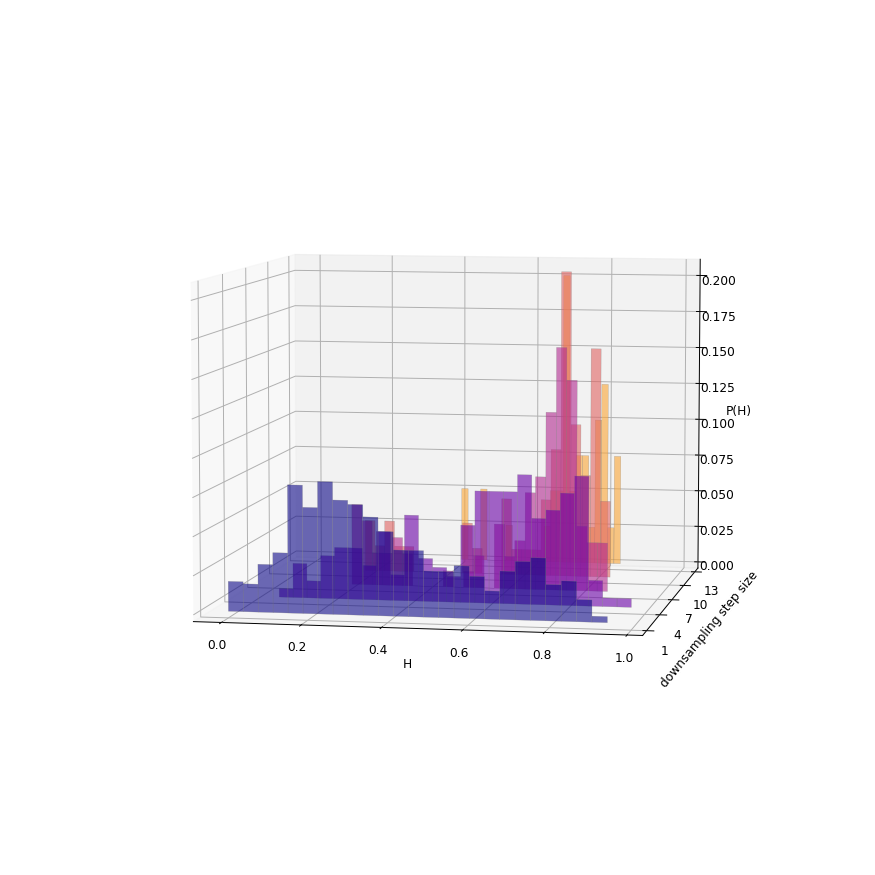

In [184]:
def plot_3d(h_avg_dict,n_bins):
    
    %matplotlib notebook
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection="3d")
    cmap = plt.cm.plasma
    
    steps = [int(s) for s in list(h_avg_dict)]
    yticks = np.array(steps)
    
    norm_counts,bins = get_hist_h(h_avg_dict,n_bins)

    for i,_ in enumerate(steps):
        ytick = yticks[i]
        temp_counts = norm_counts[i]
        temp_bins = bins[i]
        xcenter = np.convolve(temp_bins, np.ones(2), "valid")/2
        xwidth = np.diff(temp_bins)
        ax.bar(left=xcenter, height=temp_counts, width=xwidth, zs=ytick,
               zdir="y", color=cmap(i/len(yticks)), alpha=0.6, edgecolor="grey", linewidth=0.3)

    ax.set_xlabel("H")
    ax.set_ylabel("downsampling step size")
    ax.set_zlabel("P(H)")

    ax.set_yticks(yticks)
    plt.show()
    
    return norm_counts,bins
    
norm_counts,bins = plot_3d(h_avg,25)

In [185]:
# first of all, let's confirm the optimal number of components
def optimum_components(data,n_max,plot=0):
    bics = []
    aics = []
    min_bic = 0
    min_aic = 0
    b_counter=1
    a_counter=1
    for i in np.arange(1,n_max-1): # test the AIC/BIC metric between 1 and 10 components
        gmm = GMM(n_components = i, max_iter=1000, random_state=10, covariance_type = 'full')
        labels = gmm.fit(data).predict(data)
        bic = gmm.bic(data)
        aic = gmm.aic(data)
        bics.append(bic)
        aics.append(aic)
        if bic < min_bic or min_bic == 0:
            min_bic = bic
            opt_bic = b_counter
        b_counter +=1
        if aic < min_aic or min_aic == 0:
            min_aic = aic
            opt_aic = a_counter
        a_counter +=1
    
    if plot==1:    
        fig,ax = plt.subplots(figsize=(10, 4))
        # Plot 1
        plt.plot(np.arange(1,n_max-1), bics, 'o-', lw=3, c='black', label='BIC')
        plt.plot(np.arange(1,n_max-1), aics, 'o-', lw=3, label='AIC')
        plt.legend(frameon=False, fontsize=15)
        plt.xlabel('Number of components', fontsize=12)
        plt.ylabel('Bayesian Information criterion', fontsize=12)
        plt.xticks(np.arange(0,n_max, 2))
        plt.title('Opt. components = '+str(opt_bic), fontsize=20)
        plt.show()

        
    return opt_bic,bics


#data_temp = np.concatenate((np.random.normal(1, 1, 10000), np.random.normal(8, 2, 10000),np.random.normal(15, 3, 10000)))
#data_temp = data_temp.reshape(-1, 1)   #hist[1][1].reshape(-1,1)
#n_optimum,bic_vals = optimum_components(data_temp,10,plot=1)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<IPython.core.display.Javascript object>


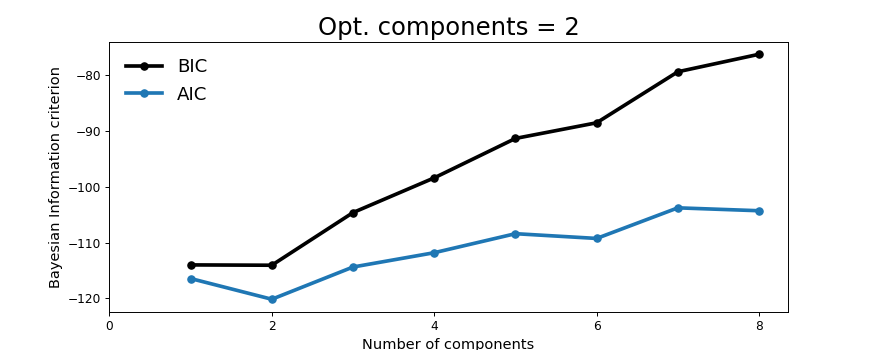

<IPython.core.display.Javascript object>


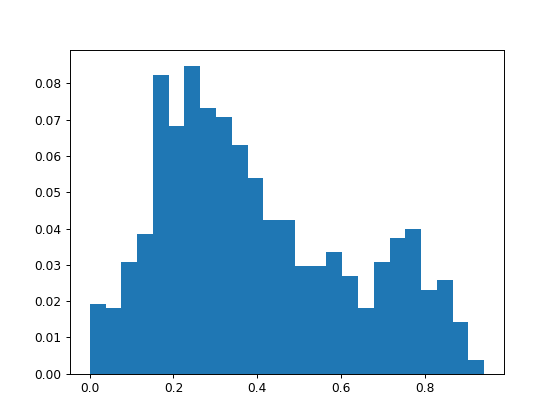

In [186]:
data_temp = norm_counts[0].reshape(-1,1)   #hist[1][1].reshape(-1,1)
n_optimum,bic_vals = optimum_components(data_temp,10,plot=1)

fig,ax = plt.subplots()
plt.hist(bins[0][:-1], bins[0], weights=data_temp)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<IPython.core.display.Javascript object>


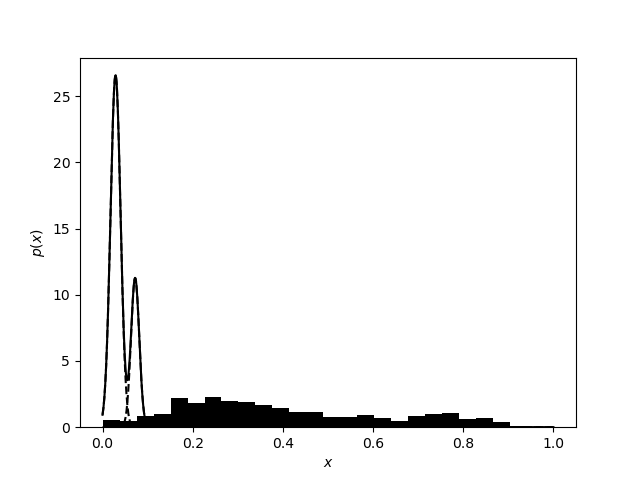

[-6.24429196e-02  1.65750168e-01  3.85876899e-01  5.97937274e-01
  8.01931292e-01  9.97858954e-01  1.18572026e+00  1.36551521e+00
  1.53724380e+00  1.70090604e+00  1.85650191e+00  2.00403144e+00
  2.14349460e+00  2.27489141e+00  2.39822187e+00  2.51348596e+00
  2.62068370e+00  2.71981509e+00  2.81088012e+00  2.89387880e+00
  2.96881113e+00  3.03567712e+00  3.09447678e+00  3.14521011e+00
  3.18787715e+00  3.22247795e+00  3.24901258e+00  3.26748118e+00
  3.27788394e+00  3.28022124e+00  3.27449367e+00  3.26070220e+00
  3.23884843e+00  3.20893497e+00  3.17096609e+00  3.12494866e+00
  3.07089382e+00  3.00881940e+00  2.93875397e+00  2.86074298e+00
  2.77485845e+00  2.68121395e+00  2.57998762e+00  2.47145717e+00
  2.35605262e+00  2.23443414e+00  2.10760425e+00  1.97706348e+00
  1.84501299e+00  1.71459118e+00  1.59009330e+00  1.47705901e+00
  1.38203919e+00  1.31183952e+00  1.27220559e+00  1.26629965e+00
  1.29367757e+00  1.35036372e+00  1.42998003e+00  1.52528547e+00
  1.62944212e+00  1.73670

Text(0, 0.5, '$p(x)$')

In [199]:
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GMM(N[i]).fit(data_temp)
    
# compute the AIC and the BIC
AIC = [m.aic(data_temp) for m in models]
BIC = [m.bic(data_temp) for m in models]

fig,ax = plt.subplots()
M_best = models[np.argmin(AIC)]


x_axis = np.linspace(0, 1, 1000)
logprob = M_best.score_samples(x_axis.reshape(-1, 1))

print(logprob)
responsibilities = M_best.predict_proba(x_axis.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.hist(bins[0][:-1], bins[0], density='true',weights=data_temp,color='black')
ax.plot(x_axis, pdf, '-k')
ax.plot(x_axis, pdf_individual, '--k')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

<IPython.core.display.Javascript object>


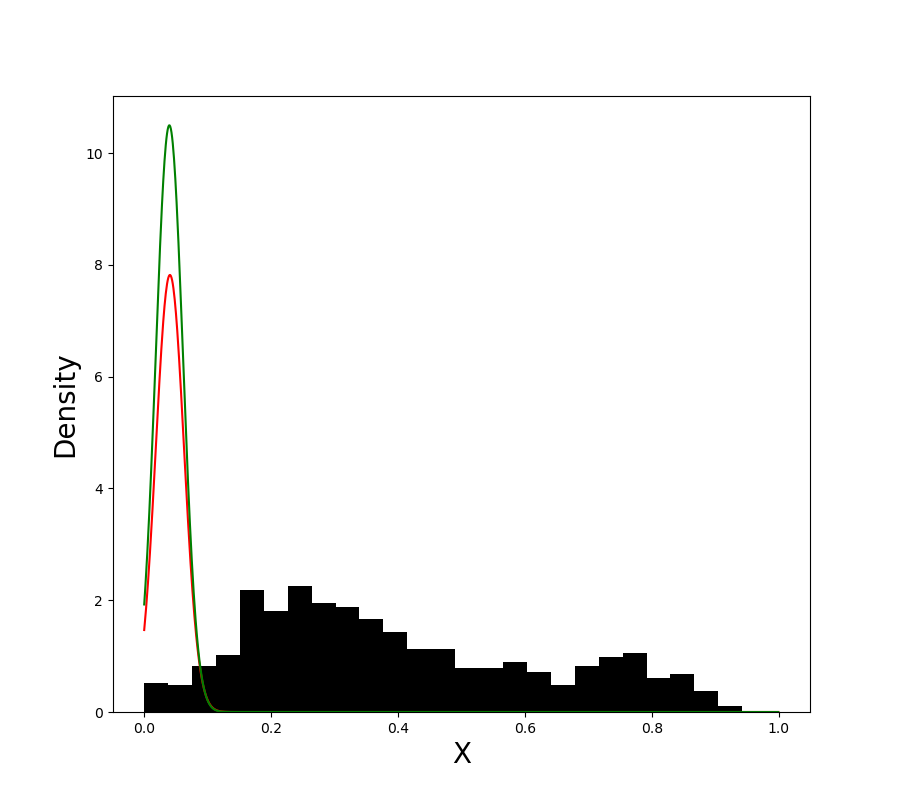

[0.         0.03768633 0.07537267 0.113059   0.15074533 0.18843167
 0.226118   0.26380434 0.30149067 0.339177   0.37686334 0.41454967
 0.452236   0.48992234 0.52760867 0.565295   0.60298134 0.64066767
 0.67835401 0.71604034 0.75372667 0.79141301 0.82909934 0.86678567
 0.90447201 0.94215834]


In [202]:
gmm = GMM(n_components = 2, max_iter=1000, random_state=0, covariance_type = 'full',init_params = 'random',tol=1e-3).fit(data_temp)

# find useful parameters
mean = gmm.fit(data_temp).means_  
covs  = gmm.fit(data_temp).covariances_
weights = gmm.fit(data_temp).weights_

x_axis = np.arange(0,1,0.001)

# create necessary things to plot
g1 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
g2 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 1st gaussian
#g3 = norm.pdf(x_axis, float(mean[2][0]), np.sqrt(float(covs[2][0][0])))*weights[2] # 1st gaussian
#g4 = norm.pdf(x_axis, float(mean[3][0]), np.sqrt(float(covs[3][0][0])))*weights[3] # 1st gaussian
#g5 = norm.pdf(x_axis, float(mean[4][0]), np.sqrt(float(covs[4][0][0])))*weights[4] # 1st gaussian
#g6 = norm.pdf(x_axis, float(mean[5][0]), np.sqrt(float(covs[5][0][0])))*weights[5] # 1st gaussian

fig,ax = plt.subplots(figsize=(9,8))
# Plot 2
plt.hist(bins[0][:-1], bins[0], density='true',weights=data_temp,color='black')
plt.plot(x_axis, g1, c='r')
plt.plot(x_axis, g2, c='g')
#plt.plot(x_axis, g3, c='b')
#plt.plot(x_axis, g4, c='r')
#plt.plot(x_axis, g5, c='g')
#plt.plot(x_axis, g6, c='b')
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)

plt.show()

print(bins[0])

In [90]:
# create GMM model object
gmm = GMM(n_components = n_optimum, max_iter=1000, random_state=5, covariance_type = 'full')

# find useful parameters
mean = gmm.fit(data_temp).means_  
covs  = gmm.fit(data_temp).covariances_
weights = gmm.fit(data_temp).weights_

x_axis = np.arange(-50, 50, 0.1)

# create necessary things to plot
g1 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
g2 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[0][0][0])))*weights[1] # 1st gaussian
g3 = norm.pdf(x_axis, float(mean[2][0]), np.sqrt(float(covs[0][0][0])))*weights[2] # 1st gaussian

fig,ax = plt.subplots(figsize=(9,8))
# Plot 2
plt.hist(data_temp, density=True, color='black',bins=10)
plt.plot(x_axis, g1, c='r')
plt.plot(x_axis, g2, c='g')
plt.plot(x_axis, g3, c='b')
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


IndexError: index 1 is out of bounds for axis 0 with size 1

## Meeting with Dr. Waigh 20/10/2022

Notes before meeting:
- Produced histograms of P(H) vs H for different downsampling steps
- Plotted in 3D, shows tendency to unimodal distribution, with high H , for high downsampling
- Displays trend to more directed behaviour
- Established code to find gaussian mixtures 

Next: 
- Upscale to treat full cohort of data, maybe average across for better stats?
- Finalise gaussian mixture and use with our data/3d plots

Questions:
- should we average displacement or H
- why would the histograms be different, training? 
- CNNS? wavenet?
- more detailed considerations, like sinusoidal fractal component and contact inhibition?

----------------------------------------------------------------------------------------------

Feedback:
- increase bin size, 2x bigger 
- count and normalise, not mean, area must be one overall
- plotting the tracks in 3D
- do with different mutants 
- look into normalisation for histograms 
- quantify differences when using model with code (CPU vs GPU)
- feature engineering issues , models fit scaling exponenent and alpha 
- haemocyte data 

Ideas: 
- Waigh mentioned developing models to account for what we observe, (sampling) time dependency of the P(h) distributions
- Trying to extend gaussian mixtures but for non-gaussian distributions, BIC over a wider model space?
- Machine learning for alpha and d-alpha 

Work plan: 
- Displacement 3D (Mila)
- Change normalisation and describe in markdown (MIla)
- Gaussian Mixture model applied to endosome data , not just example data ( Paul ) 
- Change to have just 2d histograms, perhaps 1, 3, 5,7,9,11  steps (Mila)
- Read in haemocuyte data and apply existing code
    - work on it together 20.10
    - contact t. millard about the track IDs and general structure of haemocyte data + mutant data set 
    

## Archive 

In [106]:
"""
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")

cmap = plt.cm.plasma

yticks = np.array([1,2])

for i, s in enumerate([1,2]):
    ytick = yticks[i]
    n_counts = hist[0][i]
    bins = hist[1][i]
    xcenter = np.convolve(bins, np.ones(2), "valid")/2
    xwidth = np.diff(bins)
    ax.bar(left=xcenter, height=n_counts, width=xwidth, zs=ytick,
           zdir="y", color=cmap(i/len(yticks)), alpha=0.6, edgecolor="grey", linewidth=0.3)
    
ax.set_xlabel("H")
ax.set_ylabel("downsampling step size")
ax.set_zlabel("P(H)")

ax.set_yticks(yticks)
plt.show()

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-106-f9cbf3fb5ad8>, line 24)